In [4]:
import pandas as pd
from math import sqrt 
import numpy as np
import functools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
from IPython.display import clear_output
import sys
sys.path.append('/home/skw24/python_modules')
import bacteria2
import nucs
                
import json

Compares a set of pre-existing signatures with those from cosmic
normalised to the set of quads got from the human exome.

To use this it's necessary to download the human exome in fasta
format.

The approach taken is that the individual signatures are compared using cosine similarity, and then compare the results with those obtained randomly.

In [3]:
global_results_path = lambda string: os.path.join(os.getcwd(),
                                                 'results',
                                                 string)


In [ ]:
def hs_background():
    '''make the background exome quad rate'''
    
    pth = 'homo_sapiens_background_quad_rate.csv'
    if not os.path.isfile(pth):

        hs_gene_path = input('path to human exome in fasta format ')
        if hs_gene_path = '':
            hs_gene_path = '/home/skw24/Data1/CCDS_nucleotide.current.fna'


        with open(hs_gene_path) as f:
            gene_fastas = f.read().split('>')[1:]
        gene_seq = [''.join(i.split('\n')[1:]) for i in gene_fastas]

        all_codons = [i+j+k for i in 'ACGT' for j in 'ACGT' for k in 'ACGT']
        codons32 = [i+j+k for i in 'ACGT' for j in 'CT' 
                      for k in 'ACGT']

        def get_codon_count(seq):
            vc = pd.Series([seq[i:i+3] for i in range(0,len(seq),3)]
                          ).value_counts()
            return vc.reindex(all_codons).fillna(0).astype(int)

        def ct_codon(x):
            '''reverses the order of read of mutation if not CT for use with codons'''
            try:
                comp = {'A':'T','C':'G','G':'C','T':'A'}
                if x[1] in 'CT':
                    return x
                else:
                    return ''.join([comp[i] for i in x])
            except (KeyError,IndexError):
                return ''

        def quad_option(codon):
            i,j,k = codon
            return [''.join([i,j,l,k]) for l in 'ACGT' if l!=j]

        def get_quad_count96(series):
            '''turn a value count of codons into a value count of quads'''
            quad_list = [(i,series[j]) 
                        for j in codons32 for i in quad_option(j) ]
            return pd.Series(dict(quad_list)).reindex(
                bacteria1.quadruplets_sorted)

        vc_good = pd.Series(0,index = all_codons)
        for i,seq in enumerate(gene_seq):
            vc_good+=get_codon_count(seq)
            if i%1000==0:
                print(i)
                clear_output(wait = True)
        vc_good.index = vc_good.index.map(ct_codon)
        codon_count32 = vc_good.groupby(level = 0).sum()

        quad_count96 = get_quad_count96(codon_count32)

        quad_count96/=quad_count96.sum()

        quad_count96.to_csv(pth,
                            header = False)
        
        else:

            quad_count96= pd.read_csv(pth,
                                      index_col = 0,
                                        header = None,
                                      squeeze = True)
        return quad_count96

In [ ]:
def make_cancer_normed_signatures():
    """The purpose of this is to take the cosmic mutational 
    signatures and normalise them by the exomic frequency
    of the different quads"""
    
    
    cancer_path = input('''Before this next part can be used
    the cancer probabilities need to be downloaded from

    https://cancer.sanger.ac.uk/cancergenome/assets/signatures_probabilities.txt
    Enter the path to the signatures here 
    ''')
    if cancer_path == '':
        cancer_path = '/home/skw24/Data/signature_probabilities.txt'
    df = pd.read_csv(cancer_path,
                index_col = 0, header = 0,sep = '\t')


    df = df.iloc[:,2:-8]

    df.index = nucs.quadruplets_sorted

    quad_count96 = hs_background()
    df = df.apply(lambda col: col/quad_count96)
    df = df.apply(lambda col:col/col.sum())

    df.to_csv(global_results_path('cancer_normed_sigs.csv'))

    df = pd.read_csv(global_results_path('cancer_normed_sigs.csv'),
                    index_col = 0)
    df.columns = ['cancer'+i[10:] for i in df.columns]
    return df


In [ ]:
def get_des():
    sig_des_path = input(""" python_modules includes a json file
    signature_descriptions.json. Input the path to that file here
    """)
    if sig_des_path == '':
        sig_des_path = '/home/skw24/Data1/signature_descriptions.json'
    with open(sig_des_path) as f:
        sig_des = json.load(f)

    short_des=['methyl deamination',
     'AID/APOBEC',
     'DNA HR',
     'tobacco',
     'unknown',
     'MMR',
     'UV',
     'unknown',
     'AID',
     'POLE',
     'alkylating agents',
     'unknown',
     'AID/APOBEC',
     'POLE/MMR',
     'MMR',
     'unknown',
     'unknown',
     'ROS',
     'unknown',
     'DNA MMR',
     'DNA MMR',
     'aristolochic acid',
     'unknown',
     'aflatoxin',
     'unknown',
     'DNA MMR',
     'artefact',
     'unknown',
     'tobacco',
     'NTHL1/BER']
    return sig_des,short_des



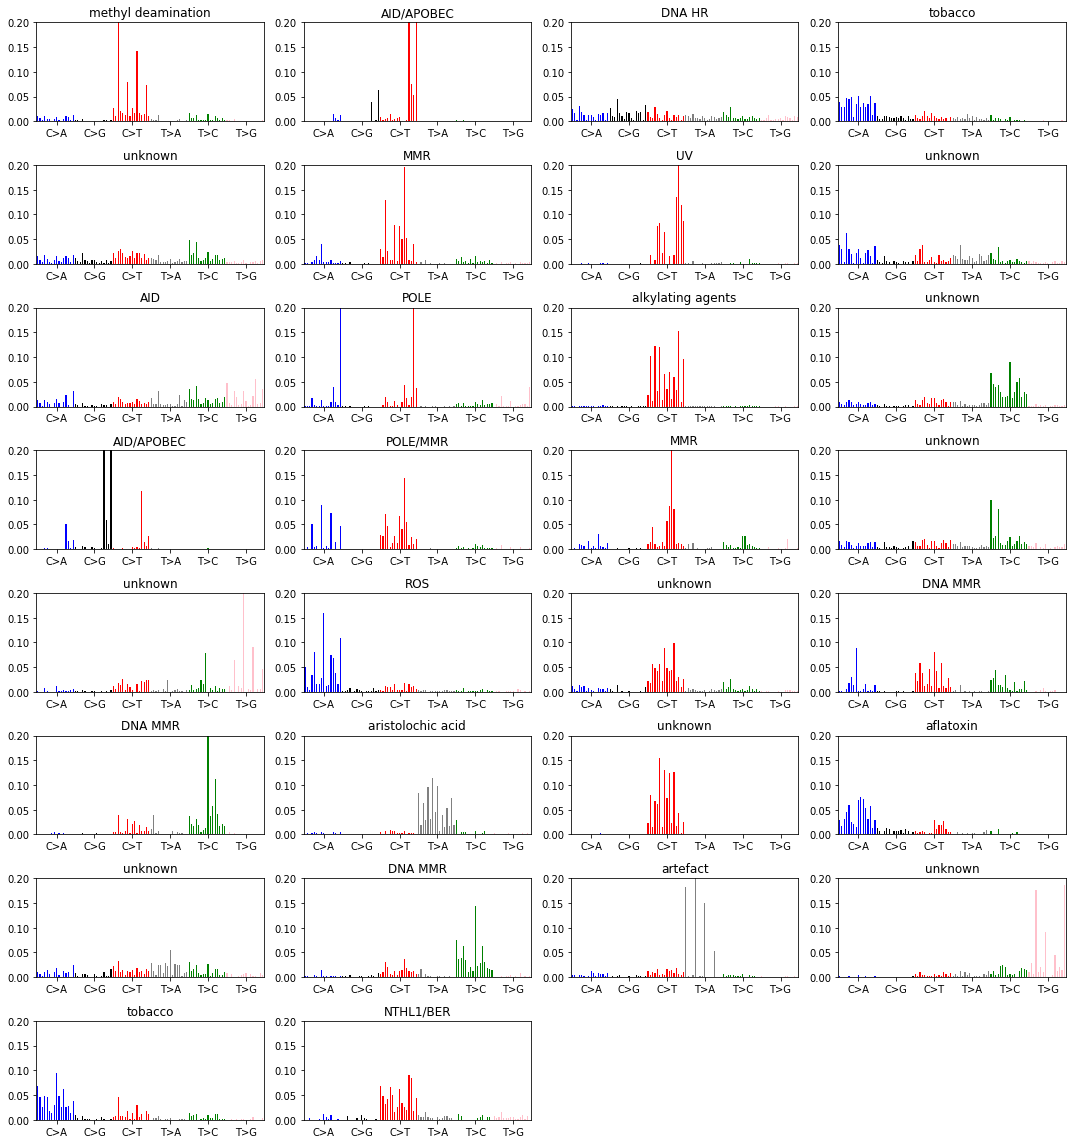

In [17]:
def show(cosmic_sigs,short_des):
    '''display a set of cosmic signatures made in the 
    function above'''
    fig,axarr = plt.subplots(8,4, figsize = (15,16))
    for i in range(30):
        ax = axarr[i//4][i%4]
        nucs.plot_quads(cosmic_sigs.iloc[:,i],ax = ax)
        ax.set_title(short_des[i])
        ax.set_ylim(0,0.2)
    axarr[7][2].set_axis_off()
    axarr[7][3].set_axis_off()
    plt.tight_layout()
    fig.savefig(global_results_path('cancer_normed_sigs.pdf'))
    

In [4]:
def load_tog_bacsigs():
    """I've included two files tog_mut_sigs.csv and
    median_signatures.csv This loads them
    """
    tog_bacsigs_path = input('path to tog_mut_sigs.csv ')
    if tog_bacsigs_path == '':
        tog_bacsigs_path = global_results_path('tog_mut_sigs.csv')
    mean_sigs_path = input('path to median_signatures.csv ')
    if mean_sigs_path =='':
        mean_sigs_path = global_results_path('median_signatures.csv')

    tog_bacsigs = pd.read_csv(tog_bacsigs_path
                              ,index_col = 0)
    bacsigs = pd.read_csv(mean_sigs_path,
                         index_col = 0)

    bacsigs.columns = ['bac'+i[4:] for i in bacsigs.columns]
    return tog_bacsigs,bacsigs

In [ ]:
def getcs(series,df):
    '''make a series of cos_sim similarities between
    the signatures in df and that in the series'''
    
    index = df.columns
    comparison = pd.Series(index = df.columns)
    for i in df.columns:
        comparison.at[i]=nucs.cos_sim(df[i].values,
                                   series.values)
    comparison.name = series.name

    return comparison

In [18]:
def stack_similarities(df,tog_bacsigs):
    """compare the signatures in df with those in tog_bacsigs"""
    similarities_df = pd.DataFrame([getcs(tog_bacsigs.iloc[:,i],
                                          df) 
                                for i in range(tog_bacsigs.shape[1])])

    return similarities_df.stack().sort_values(
        ascending = False)

In [ ]:
def get_rand_cs(series,rand):
    return  sorted([nucs.cos_sim(rand[:,i],
                            series.values)
                    for i in range(100000)])[::-1]+[0]

def prob(ind):
    b,c = ind
    rand = np.random.rand(96,100000)
    rand_cs = get_rand_cs(tog_bacsigs[b],rand)

    return next((i for i in range(100001) 
        if rand_cs[i]<similarities[ind]))/100000

In [ ]:
def scientific_not(x):
    if x == 0:
        return '<E-05'
    else: 
        return '{:.0E}'.format(float(x))

In [44]:
def show_matches( sig, tog_bacsigs,j,short_des):
    '''shows 10 matches, starting from
    j*10, and saves them    
    '''
    if j==5:
        mx = 3
    else:
        mx = 10
    therange = range(mx)
    fig,axarr = plt.subplots(mx,2,figsize = (7,mx*2.5))


    for i in therange:
        try:
            a,p,b,c = sig.iloc[j*10+i]

            ax = axarr[i][0]
            ax.set_ylim(0,0.2)
            ax.set_title('{}\ncos sim={}, pvalue {}'.format(b,a,p))
            nucs.plot_quads(tog_bacsigs[b],ax = ax)

            ax = axarr[i][1]
            ax.set_ylim(0,0.2)
            title = '{}\n cause {}'.format(c,short_des[
                int(c.split('cancer')[-1])])
            ax.set_title(title)
            nucs.plot_quads(df[c],ax = ax)
        except:
            pass

    plt.tight_layout()
    fig.savefig(global_results_path(
        'matched_bac_cancer{}.pdf'.format(j)))

In [ ]:
def make_significant_matches():
    '''compare the cosmic signatures normalised
    for the human exome against those generated for 
    the bacteria'''
    
    sig_des,short_des = get_des()
    sig_path = global_results_path('sig_match.csv')
    
    if not os.path.isfile(sig_path):
        cosmic_sigs = make_cancer_normed_signatures()
        similarities = stack_similarities(cosmic_sigs,tog_bacsigs)
        good_sims = similarities[similarities>0.65]
        
        sim_df = pd.DataFrame(similarities)
        sim_df.columns = ['alignment']
        sim_df['prob'] = 'not sig'

        for i,ind in enumerate(similarities.index):
            p = prob(ind)*(i+1)
            sim_df.at[ind,'prob']  = p
            print(i,' ',p,' ',100*i/4350)
            clear_output(wait = True)
            if p>0.5:
                break


        sim_df_calc = sim_df.loc[sim_df['prob']!='not sig']
        sig = sim_df_calc.loc[sim_df_calc['prob']<0.05]
        sig['bac'] = pd.Series([i[0] for i in sig.index],
                              index = sig.index)
        sig['cancer'] = pd.Series([i[1] for i in sig.index],
                               index = sig.index)
        sig.index = range(sig.shape[0])
        sig.columns = ['alignment']+list(sig.columns[1:])

        sig['prob']=sig['prob'].map(scientific_not)
        sig['alignment']=sig['alignment'].map(lambda x: round(x,2))
        sig.to_csv(sig_path)
    else:
        sig = pd.read_csv(sig_path,
                          index_col = 0)
    for j in range(sig.shape[0]//10+1):
        show_matches( sig,tog_bacsigs,j,short_des)
    
    return sig